In [34]:
#pip install transformers==4.30.2

In [23]:
#pip install focal_loss_torch

In [24]:
#pip install torchmetrics

In [167]:
#pip install emoji

In [4]:
#pip install pymorphy2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets,models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
from tqdm import tqdm
import os
import zipfile
import seaborn as sns
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from nltk.stem.snowball import RussianStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
import torchmetrics
from torchmetrics.classification import MultilabelF1Score
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from gensim.models import Word2Vec
from collections import Counter
from nltk.tokenize import word_tokenize
from transformers import AutoModel, AutoTokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [2]:
#!kaggle competitions download -c dl-2025-study-competition-2

100%|██████████| 12.9M/12.9M [00:01<00:00, 9.87MB/s]


In [3]:
with zipfile.ZipFile("dl-2025-study-competition-2.zip", 'r') as zip_ref:
      zip_ref.extractall("content2/")  

In [15]:
df=pd.read_csv('content2/train.csv')


# Часть 1 (анализ датасета)

In [65]:
print(len(df))
print(df.labels.nunique())
#уникальных наборов классов 3540

29568
3540


In [20]:
#смотрим на то, что у нас тут вообще понаписано 
for i in range(10):
    print(i, f":", df.text[i])

0 : 15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе "Отдых"
📍
Запись обязательно +73472228532
1 : 13 и 14 августа
Выходные в Меге
https://t.me/megaufa_official
Мегапарк
2 : Йокнапатофа
Постановка Театр им. Маяковского
Билеты от 500 до 2000 р.
3 : Впервые в Уфе танцевальная терапия в группе с практикующим психологом
Тема встречи: «Отношения. Доверие. Контакт»
Приходите, если:
🔸
вы хотите наладить или поисследовать свои отношения с
-  телом
- собой
- близким человеком
- работой
- деньгами
🔸
не можете разрешить или забыть какую-то  ситуацию, связанную с отношениями
🔸
не умеете доверять или делегировать
🔸
тяжело вступаете в контакт
Задать вопрос психологу курса
и записаться можно здесь:
@LeontevaKsenia
Дата
: 26 января
Время
: 19.00-21.00
Адрес
: Коммунистическая, 45/3, Б/ц "Деловой двор"
Стоимость: 1500
Что нужно для занятия:
удобная одежда, носки, вода, желание танцевать.
4 : 🎹
GRAND PIANO COMPETITION
🎹
Друзья, сегодня открытие IV Международного конкурса G

Реклама: выкинуть все не буквенные символы, url, смайлы, привести все к одному регистру 

надо подумать над тем,что делать с англ словами

In [29]:
len(df.labels[0].split(' '))

20

всего 20 классов 

In [53]:
df[df.isna().any(axis=1)]

,id,text,labels


In [50]:
range(9)

range(0, 9)

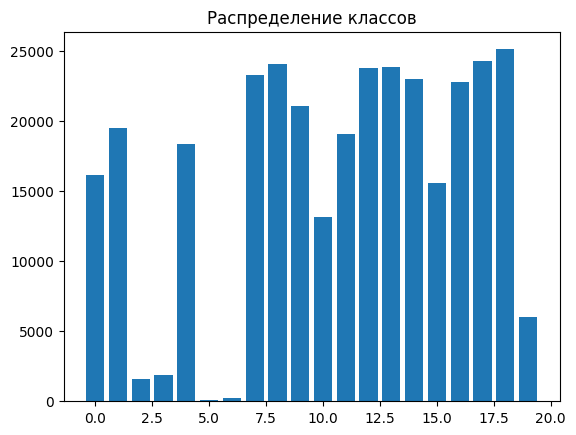

In [64]:
clas=np.array([np.fromstring(row, dtype=int, sep=' ') for row in df_mixed['labels'].values])
plt.bar(np.arange(20),np.sum(clas,axis=0))
plt.title('Распределение классов');

In [58]:
df['count']=df.labels.apply(lambda x: sum([int(i) for i in x.split(' ')]))


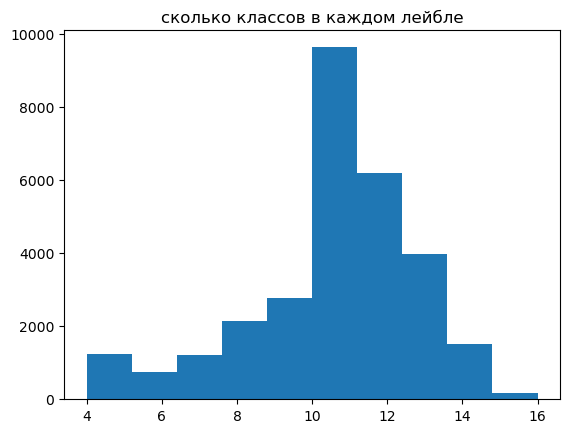

In [64]:
plt.hist(df['count'].values)
plt.title('сколько классов в каждом лейбле');

Преимущественно каждый текст относится к 10-12 классам, интересно что в целом есть смешение на отношение текста к большему количеству классов, те сами текста очень разносторонние и попадают сразу под несколько категорий 

In [68]:
df['count']

0         9
1         7
2         6
3        13
4        11
         ..
29563     7
29564    12
29565    15
29566    10
29567    10
Name: count, Length: 29568, dtype: int64

In [73]:
print(df[df['count']<5]['text'].values[:30])

['17 ноября. День рождения Дедушки Мороза в Малинки\n🔴\nПодписывайся на\nАфишу Ростова'
 'Пионы в Царицыно\n🥰'
 'Напоминаем даты показательных кормлений в ростовском зоопарке на этот месяц'
 'Вот такие огромные грибы нашли в лесу в районе Домодедово\n🍄'
 'Ростов после дождя\n💦\n📸\nРоман Неведров\n🔴\nПодписывайся на\nАфишу Ростова'
 'Розовые фламинго из ростовского зоопарка\n😍'
 '🐼\nМилое граффити в центре Азова\n🔴\nПодписаться на Новости Ростова-на-Дону'
 '🏰\nЗдания в стиле неоготики в Москве.' 'Красавчики из парка «Лога»'
 'Зимний Ростов глазами фотографа\n📸\nДенис Демков'
 'Приворотное зелье\nПостановка Театральная компания «Маскарад»'
 'Красавица Маша из нашего зоопарка!\n🔴\nПодписывайся на\nАфишу Ростова'
 'Радужное небо над Красным Сулином\n😍\n🔴\nПодписывайся на\nАфишу Ростова'
 'Селивановская, Ростовская область'
 'Гребной канал\n😍\nПрогулка на велосипедах' 'Александровский сад'
 'Таганрог. Интересный дом с историей на Комсомольском бульваре'
 'Яркий день в парке им. А.Собино\n🔴\

In [76]:
df[df['count']<5]['labels'].unique()

array(['0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1',
       '0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0',
       '0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0',
       '0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0'], dtype=object)

In [74]:
print(df[df['count']>15]['text'].values[:30])

['Симфонический рок от Melodion Orchestra и песочно-световое шоу «Моцарт Драйв»\n🏛\nКонцертный зал в центре Москвы\xa0на Поварской\n🗓\n23 ноября в 19:00\n🎫\nБилеты по ссылке здесь\n💚\n-20% по промокоду Драйв\n💚\nБокалом игристого в подарок\nВас ждёт настоящее музыкальное пиршество – микс самой популярной классики в рок-обработке и легендарных рок-хитов в симфоническом звучании: Моцарт, Вивальди, Queen, Bon Jovi, Nirvana, Metallica. Мощь, лавина эмоций, ощущения до мурашек и невероятный драйв. Все это подарит яркая игра самого известного Оркестра Melodion. А рождающиеся прямо на Ваших глазах песочные картины, добавят драйва и оставят яркие впечатления. Подарите праздник себе и близким.\n🥰\nБилеты со скидками\n@teatr_msk'
 'Спектакль "Ты слишком много куришь, Лили"\n🏛\nБоярские Палаты СТД РФ\n🗓\n13 сентября в 19.00\n🗓\n20 сентября в 19.00\n🎫\nБилеты\n🎫\n-50% по промокоду\xa0 «ЛИЛИ12» действует до 13.09.2023\nСпектакль «Ты слишком много куришь, Лили», затрагивающий такую щепетильную тему 

In [80]:
df[df['count']>15]['labels'].unique()

array(['1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0',
       '1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0'], dtype=object)

Текста у которых мало классов в целом очень маленькие и короткие; и наоборот текста с самым большим срдержанием классов длинные даже имеюткакую-то синтаксическую структуру 

Проблемы с подбором окна: для длинных текстов с большим содержанием классов нужно большое окно

Также в обеих категориях видно, что очень мало уникальных значений и очень большая часть меток классов у них совпадает 

In [143]:
df.text.apply(lambda x: all(ord(c) <128 for c in x)).sum() #упоротый метод проверки на наличие англ слов 

27

У нас есть 27 текстов только с англ словами (если all заменить на any, то толку особо нет тк практически в каждом тескте есть /n, который даст True)

Чекнем, что за слова

In [203]:
t=df.text.apply(lambda x: all(ord(c) <128 for c in x))
idx=t[t==True].index
engl=df.iloc[idx]

In [204]:
engl[:5]

,id,text,labels,count
980,980,https://vk.com/wall-8888887_26857,0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1,6
1493,1493,https://t.me/nastoyashieotnoshenia?livestream,1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1,7
2795,2795,https://vk.com/wall-8888887_25773,0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1,6
3815,3815,https://vk.com/wall-8888887_26483,0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1,6
5129,5129,https://mos-kino.ru/event/sinemateka-8-marta/,1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1,7


Это все какие-то ссылки или вообще что-то не особо понятное, интересно что они все имеют около 6-7 отношений к классам и классы +- одинаковые

Посмотрим на тексты, где есть русский-английский и только русский

In [201]:
h=df.text.apply(lambda x: re.sub(r'[^A-Za-zА-Яа-яЁё]', '', x))
# убрали все кроме русских и английский букв 
h.apply(lambda x: any(ord(c) <128 for c in x)).sum() # а всего данных у нас 29568

23395

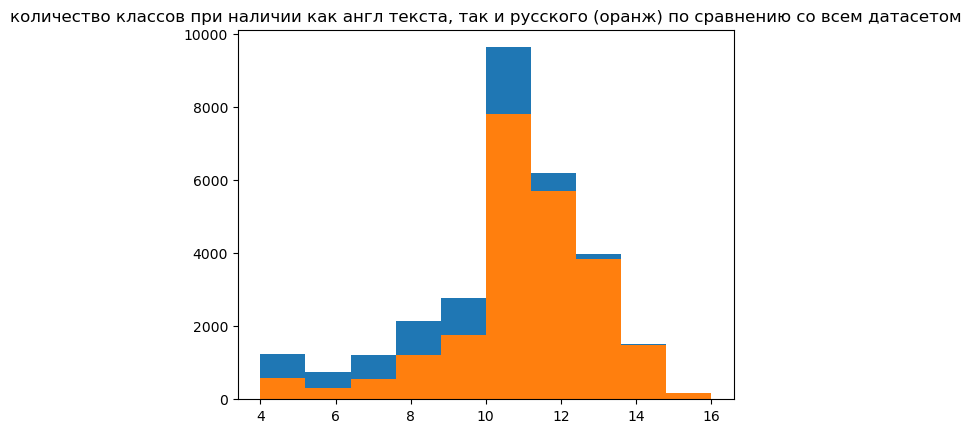

In [205]:
idx=h[h.apply(lambda x: any(ord(c) <128 for c in x))].index
engl_rus=df.iloc[idx]

plt.hist(df['count'])
plt.hist(engl_rus['count'])
plt.title('количество классов при наличии как англ текста, так и русского (оранж) по сравнению со всем датасетом');

In [208]:
#текст только на русском 
t=h.apply(lambda x: all(ord(c) >128 for c in x))
idx=t[t==True].index
rus=df.iloc[idx]

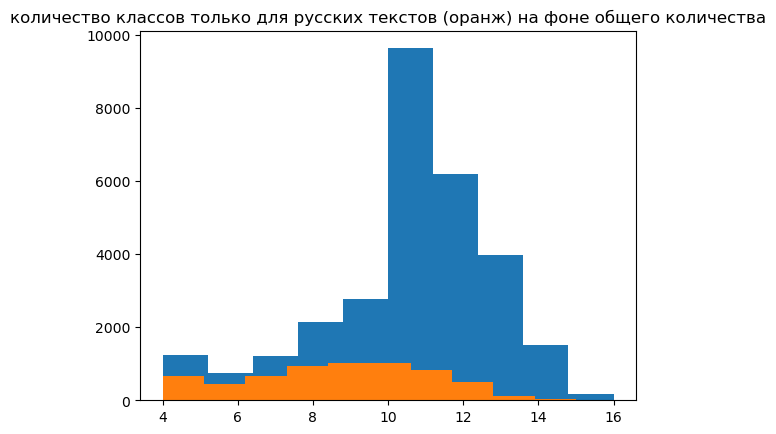

In [217]:
plt.hist(df['count'])
plt.hist(rus['count'])
plt.title('количество классов только для русских текстов (оранж) на фоне общего количества');

Интересные замечания: текста, где содержиться только руссский язык преимущественно не относятся к большому количеству классов, и наоборот если текст англ+рус,
то он будет относиться к большому колчеству классов (почти все текста, имеющие 12+ классов имеют и рус и англ языки)

# Часть 2 и Часть 3: какие способы очистки текста нужны под разные способы токенезации и заданию эмбеддингов + обучить модельки 
(1) tf-idf + любая нейронная сеть; 

(2) w2v + любая нейронная сеть; 

(3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях; 

(4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях; 

(5) эмбеддер + решение на bert-like моделях (любой вид). 


##### Технический код: стоп слова, что-то спертое из семов и определение стоп-слов, лемматизации и стемминга для англ/рус

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience #отвечает за период в течении которого не улучшается метрика 
        self.verbose = verbose
        self.counter = 0 #счетчик увеличивается каждую эпоху, если не было улучшения 
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta: #делта чтобы не сохранялись совсем маленькие приросты 
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
            
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs: # пока идут эпохт вормапа lr изменяется по определенному закону 
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer  

In [11]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:

nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
import inspect
if not hasattr(inspect, 'getargspec'):
    import collections
    def getargspec(func):
        sig = inspect.signature(func)
        args = []
        varargs = None
        varkw = None
        defaults = []
        for param in sig.parameters.values():
            if param.kind == param.VAR_POSITIONAL:
                varargs = param.name
            elif param.kind == param.VAR_KEYWORD:
                varkw = param.name
            else:
                args.append(param.name)
                if param.default is not param.empty:
                    defaults.append(param.default)
        return collections.namedtuple('ArgSpec', 'args varargs keywords defaults')(args, varargs, varkw, tuple(defaults) if defaults else None)
    inspect.getargspec = getargspec

In [14]:
lemmer_rus = pymorphy2.MorphAnalyzer() 
lemmer_eng = WordNetLemmatizer()
#лемматизация 
stemmer_rus = RussianStemmer()
stemmer_eng =PorterStemmer()#стемматизация

stop_words_rus = set(stopwords.words('russian'))
stop_words_eng =set(stopwords.words('english'))

### 1. TF-IDF + любая нейронная сеть способы очистки 

Убрать стоп слова, все к одному регистру, всякий мусор кроме букв навыкид, лемматизация/стемминг на выбор

Есть англ слова, пока уберем, но потом может надо будет с ними посмотреть тк у нас большая часть датасета на это опирается 

спойлер: ничего особо то и не поменялось f1-score вырос с 0.83 до 0.84 (до 9й эпохи) потом опять начал падать 


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [33]:
def tf_idf_rus(text, method='lemmer'):
    text = text.lower()
    text = re.sub(r'[^а-яё\s-]', '', text)
    text = re.sub(r'-',' ',text)
    tokens = text.split()
    if method == 'lemmer':
        tokens = [lemmer_rus.parse(token)[0].normal_form for token in tokens]
    elif method == 'stemmer':
        tokens = [stemmer_rus.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words_rus and len(token) > 2]
    return ' '.join(tokens)

Посмотрим еще как будет отрабатывать, если англ слова не выкидывать 

In [75]:
#с учетом обоих языков 
def tf_idf(text):
    
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #удаляем ссылки 
    text = re.sub(r'@\S+', '', text) #удаляем теги почт и тг
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s-]', '', text)  #убираем все кроме рус/англ букв и - 
    text = re.sub(r'-',' ',text) #были слова по типу "перфоманс-инсталляция" сделали так чтобы убрать - и не было слипаний 
    
    tokens = text.split()
    #для русского лемматизация для английского стемминг
    tokens = [lemmer_rus.parse(token)[0].normal_form if re.search('[а-яё]', token) else stemmer_eng.stem(token) for token in tokens]
    
    tokens = [token for token in tokens if token not in (stop_words_eng and stop_words_rus) and len(token) > 2]
    return ' '.join(tokens)

In [63]:
df['clean_text']= df.text.apply(lambda x: tf_idf(x))

In [89]:
df['clean_text_rus']= df.text.apply(lambda x: tf_idf_rus(x,method='lemmer'))

Тут конечно не совсем правильно сделала, надо было сначала сплитануть, а потом уже фитить только трейн и на валидации обучаться, но тк потом все равно для тест пришлось бы весь трейн(без разбиения) прогонять, то оставила так 

In [90]:
tf_idf = TfidfVectorizer(
    max_df=0.95,      
    min_df=1,
    norm='l2',        
sublinear_tf=True
)
X = tf_idf.fit_transform(df.clean_text_rus) 
X_tensor = torch.FloatTensor(X.toarray())

In [91]:
X.shape #47618 уникальных слов было без англ 

(29568, 44092)

In [92]:
labels_tensor=torch.FloatTensor(np.array([np.fromstring(row, dtype=int, sep=' ') for row in df['labels'].values]))

In [93]:
class My_Dataset(Dataset):
    def __init__(self, text, label, split='train'):
        n=text.shape[0]
        self.split=split
        if self.split == 'train':
            self.text=text[:int(n*0.7)]
            self.label=label[:int(n*0.7)]
        elif self.split == 'val':
            self.text=text[int(n*0.7):]
            self.label=label[int(n*0.7):]
        else:
            self.text=text
            self.label=label
                
    def __len__(self):
        return self.text.shape[0]  

    def __getitem__(self, idx):
        return self.text[idx], self.label[idx]

In [94]:
train_dataset=My_Dataset(X_tensor,labels_tensor,split='train')
val_dataset=My_Dataset(X_tensor,labels_tensor,split='val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [101]:
num_classes = 20
num_uwords=X_tensor.shape[1]

model = nn.Sequential(
    nn.Linear(num_uwords,2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    
    nn.Linear(2048,1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.4),
    
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512,num_classes)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

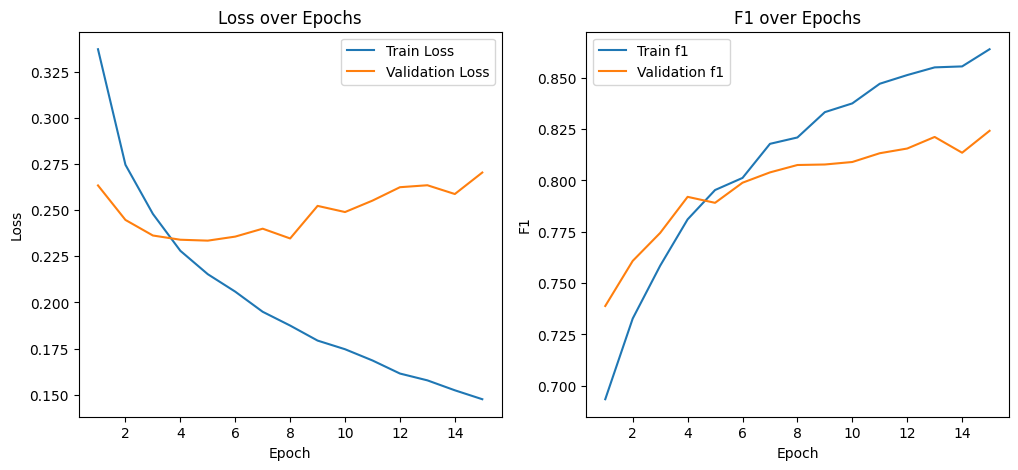

100%|██████████| 15/15 [06:22<00:00, 25.50s/it]

Epoch 15/15 | LR: 0.001000 | Train Loss: 0.1476, Train f1: 0.86 | Val Loss: 0.2703, Val f1: 0.82


In [99]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

metric = MultilabelF1Score(num_labels=20)  
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)
early_stopping_loss_switch = EarlyStopping(patience=2, verbose=True)

warmup_epochs = 2
base_lr = 0.01
loss_switched = False
optimizer_switched = False
num_epochs=15

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    # if epoch < warmup_epochs:
    #      optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    # else:  
    #      scheduler.step()
        
    all_preds_train = []
    all_labels_train = []
    
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets= targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        predicted =  torch.sigmoid(outputs)
        
        all_preds_train.append(predicted.cpu())
        all_labels_train.append(targets.cpu())

    all_preds_train = torch.cat(all_preds_train, dim=0)
    all_labels_train = torch.cat(all_labels_train, dim=0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc =  metric(all_preds_train,all_labels_train)
    
    all_preds_val = []
    all_labels_val = []
    
    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs).to(device)

            all_preds_val.append(predicted.cpu())
            all_labels_val.append(targets.cpu())
            
    all_preds_val = torch.cat(all_preds_val, dim=0)
    all_labels_val = torch.cat(all_labels_val, dim=0)   
    
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = metric(all_preds_val,all_labels_val)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.cpu().item())
    val_accuracies.append(val_acc.cpu().item())

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train f1")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation f1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title("F1 over Epochs")
    plt.legend()
    plt.show()
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train f1: {train_acc:.2f} | Val Loss: {val_loss:.4f}, Val f1: {val_acc:.2f}")

    # early_stopping_optimizer_switch(val_loss, model)
    # if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
    #     print("No improvement after loss switch. Switching optimizer to Adam.")
    #     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
    #     base_lr = 0.001
    #     optimizer_switched = True
    #     early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)

#### основные выводы: лютейше переобучаемся, но в целом score выдаёт неплохой (на тесте что-то около 0.82..), но лосс тут конечно, кто куда один по дрова другой в лес 

#### Выбиваем скор

In [43]:
test=pd.read_csv('content2/test.csv')

In [73]:
class test_Dataset(Dataset):
    def __init__(self, text):
            self.text=text
                
    def __len__(self):
        return self.text.shape[0]  

    def __getitem__(self, idx):
        return self.text[idx]

In [45]:
test['clean_text']= test.text.apply(lambda x: tf_idf_rus(x,method='lemmer'))

In [76]:
test['clean_text_eng']=test.text.apply(lambda x: tf_idf(x))


In [79]:
X = tf_idf.transform(test.clean_text) 
X_tensor = torch.FloatTensor(X.toarray())

In [80]:
X_tensor.shape

torch.Size([7392, 50430])

In [81]:
test_dataset=test_Dataset(X_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [82]:
model.eval()
test_predictions = []
for inputs in test_loader:
    inputs=inputs.to(device)
    with torch.no_grad():
        outputs=model(inputs)
        preds=torch.sigmoid(outputs)
        preds = (preds >= 0.5).float()
        test_predictions.extend(preds.cpu().numpy().tolist())
print(len(test_predictions))      
#df = pd.DataFrame(test_predictions, columns=['pred'])
#tags=pd.read_csv('conent2/sample_submission.csv')
#tags['target']=df.pred
#tags.to_csv('end_best_guseva.csv', index=False) 

7392


In [83]:
tags=pd.read_csv('/home/jupyter/datasphere/project/content2/sample_submission.csv')

In [84]:
tags=pd.read_csv('/home/jupyter/datasphere/project/content2/sample_submission.csv')
tags['labels']=[' '.join(map(str, map(int, i))) for i in test_predictions]
tags.to_csv('nlp_tf_idf_2.csv', index=False) 

In [85]:
tags.head()

,id,labels
0,29568,1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0
1,29569,0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2,29570,0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3,29571,0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0
4,29572,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1


In [86]:
tags.to_csv('nlp_tf_idf_2.csv', index=False) 

In [365]:
for inputs in test_loader:
    inputs=inputs.to(device)
    with torch.no_grad():
        outputs=model(inputs)
        preds=torch.sigmoid(outputs)
        preds = (preds >= 0.5).float()

In [301]:
X_tensor.shape[1]

50694

### 2. W2V + любая нейронная сеть: способы очистки

в целом тут по способам очистки ничего особо-то и не меняется единственное, что попробуем оставить пунктуацию мб это как-то повлияет на сохранение контекста и тут вопрос с англ словами тоже остается, тк все-таки они наверное не очень сильно влияют на контекст 

энивэй чекнем и с англ и без англ слов 

In [92]:
def w2v_rus(text, method='lemmer'):
    text = text.lower()
    text = re.sub(r'[^а-яё\s\,-]', '', text)
    text = re.sub(r'-',' ',text)
    tokens = text.split()
    if method == 'lemmer':
        tokens = [lemmer_rus.parse(token)[0].normal_form for token in tokens]
    elif method == 'stemmer':
        tokens = [stemmer_rus.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words_rus and len(token) > 2]
    return ' '.join(tokens)

In [311]:
def w2v(text):
    
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #удаляем ссылки 
    text = re.sub(r'@\S+', '', text) #удаляем теги почт и тг
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s-]', '', text)  #убираем все кроме рус/англ букв и - 
    text = re.sub(r'-',' ',text) #были слова по типу перфоманс-инсталляция сделали так чтобы убрать - 
    
    tokens = text.split()
    #для русского лемматизация для английского стемминг
    tokens = [lemmer_rus.parse(token)[0].normal_form if re.search('[а-яё]', token) else stemmer_eng.stem(token) for token in tokens]
    
    tokens = [token for token in tokens if token not in (stop_words_eng and stop_words_rus) and len(token) > 2]
    return ' '.join(tokens)

In [312]:
df['clean_text_w2v']= df.text.apply(lambda x: w2v(x))

In [313]:
len(df.clean_text_w2v)

29568

Блок на удаление часто/редко встречающихся слов во всем наборе тренировачного набора (пока что без деления на train/val) при этом редкие/частые слова взяты только из 70% датасета

In [314]:
df_drop=df.clean_text_w2v[:int(len(df)*0.7)]
print(len(df_drop))

doc_counts = defaultdict(int)
n_docs = len(df_drop) 
for doc in df_drop: #документ/строка 
    for word in set(doc.split()): #слово
            doc_counts[word] += 1
freq_words = {w for w, cnt in doc_counts.items() if cnt >= n_docs/5}
rare_words = {w for w, cnt in doc_counts.items() if cnt <= 10}
drop_words = freq_words.union(rare_words)

def filter_tokens(doc):
    return [w for w in doc if w not in drop_words]

full_text = [filter_tokens(doc) for doc in df.clean_text_w2v ] #убрали редко встречающиеся слова 
full_text = [''.join(doc) for doc in full_text]
len(full_text)

20697


29568

In [315]:
labels_tensor=torch.FloatTensor(np.array([np.fromstring(row, dtype=int, sep=' ') for row in df['labels'].values]))

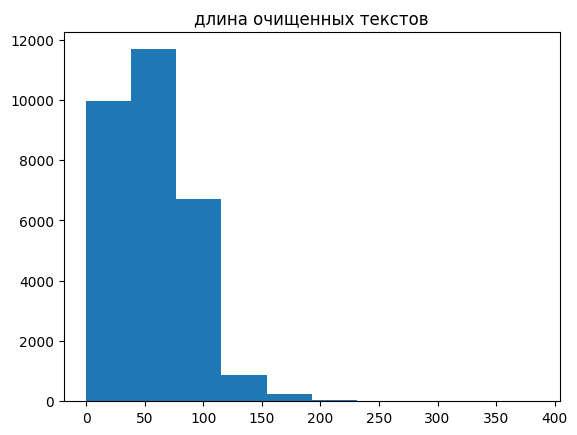

In [316]:
len_texts=[]
for i in range(len(full_text)):
    len_texts.append(len(full_text[i].split()))
plt.hist(len_texts)
plt.title('длина очищенных текстов');

медианное значение по длине текстов (очищенных) около 50, так что от каждой рекламы берем что-то около 60-70 слов; окно сначала возьмем 10, потом мб можно попытаться его увеличть (уменьшать думаю не стоит)

In [317]:
#взяли первые 70% датасета и разбили предложения на слова-токены по ним обучили w2v
train_sent = full_text[:int(len(full_text)*0.7)]
train_sent=[i.split() for i in train_sent]
w2v_model = Word2Vec(sentences=train_sent, vector_size=100, window=12,
                     min_count=1, workers=4, epochs=10)

In [322]:
class My_Dataset_w2v(Dataset):
    def __init__(self, text, label, w2v_model,split='train',max_len=70):
        n=len(text)
        self.split=split
        self.w2v=w2v_model
        self.max_len=max_len
        self.emb_dim = w2v_model.vector_size
        
        if self.split == 'train':
            self.text=text[:int(n*0.7)]
            self.label=label[:int(n*0.7)]
        elif self.split == 'val':
            self.text=text[int(n*0.7):]
            self.label=label[int(n*0.7):]
        else:
            self.text=text
            self.label=label
                
    def __len__(self):
        return len(self.text)  

    def __getitem__(self, idx):
        doc = self.text[idx].split()
        seq = [self.w2v.wv[w] if w in self.w2v.wv else np.zeros(self.emb_dim) for w in doc][:self.max_len]
        if len(seq) < self.max_len:
            seq = seq + [np.zeros(self.emb_dim)] * (self.max_len - len(seq))
        doc_tensor = torch.FloatTensor(np.array(seq))  
        return doc_tensor, self.label[idx]

In [323]:
train_dataset=My_Dataset_w2v(full_text,labels_tensor,w2v_model,split='train',max_len=70)
val_dataset=My_Dataset_w2v(full_text,labels_tensor,w2v_model,split='val',max_len=70)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [324]:
for i,_ in train_loader:
    break

In [328]:
num_classes = 20
emb_dim=w2v_model.vector_size
max_len=70

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(max_len*emb_dim,2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(p=0.7),
    
    nn.Linear(2048,1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.7),
    
    nn.Linear(1024,512),
    nn.LeakyReLU(),
    nn.Dropout(p=0.7),
    nn.Linear(512,num_classes)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

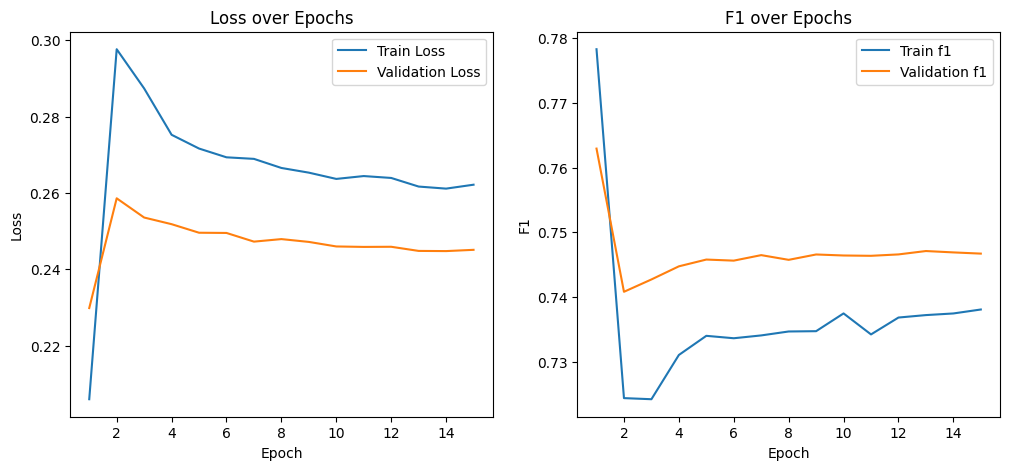

100%|██████████| 15/15 [02:07<00:00,  8.49s/it]

Epoch 15/15 | LR: 0.001000 | Train Loss: 0.2622, Train f1: 0.74 | Val Loss: 0.2451, Val f1: 0.75
EarlyStopping counter: 1 out of 3


In [330]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

metric = MultilabelF1Score(num_labels=20)  
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)
early_stopping_loss_switch = EarlyStopping(patience=2, verbose=True)

warmup_epochs = 2
base_lr = 0.01
loss_switched = False
optimizer_switched = False
num_epochs=15

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    if epoch < warmup_epochs:
         optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:  
         scheduler.step()
        
    all_preds_train = []
    all_labels_train = []
    
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets= targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        predicted =  torch.sigmoid(outputs)
        
        all_preds_train.append(predicted.cpu())
        all_labels_train.append(targets.cpu())

    all_preds_train = torch.cat(all_preds_train, dim=0)
    all_labels_train = torch.cat(all_labels_train, dim=0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc =  metric(all_preds_train,all_labels_train)
    
    all_preds_val = []
    all_labels_val = []
    
    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs).to(device)

            all_preds_val.append(predicted.cpu())
            all_labels_val.append(targets.cpu())
            
    all_preds_val = torch.cat(all_preds_val, dim=0)
    all_labels_val = torch.cat(all_labels_val, dim=0)   
    
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = metric(all_preds_val,all_labels_val)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.cpu().item())
    val_accuracies.append(val_acc.cpu().item())

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train f1")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation f1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title("F1 over Epochs")
    plt.legend()
    plt.show()
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train f1: {train_acc:.2f} | Val Loss: {val_loss:.4f}, Val f1: {val_acc:.2f}")

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

Такое себе получается, едтинственное, что радует это отсутсвие переобучения (сильного) как было с tf-idf и то скорее всего это из-за dopout в 0.7 те навесили сильную регуляризацию


### 3.Встроенный эмбеддинг в нейросетевое решение на свёрточных сетях

Как обычно: пунктуация, стоп-слова и любая символьная/численная чушь в мусор, оставляем рус слова и навешиваем на них лемматизацию (с англом еще надо подумать он не нёс особого улучшения на предыдущих двух пунктах) 

In [334]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [375]:
def cnn_rus(text, method='lemmer'):
    text = text.lower()
    text = re.sub(r'[^а-яё\s-]', '', text)
    text = re.sub(r'-',' ',text)
    tokens = text.split()
    if method == 'lemmer':
        tokens = [lemmer_rus.parse(token)[0].normal_form for token in tokens]
    elif method == 'stemmer':
        tokens = [stemmer_rus.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words_rus and len(token) > 2]
    return ' '.join(tokens)

In [376]:
df['clean_text_cnn']= df.text.apply(lambda x: cnn_rus(x,'lemmer'))

In [377]:
df.clean_text_cnn.values

array(['январь детский развлекательный программа бесплатно кафе отдых запись обязательно',
       'август выходной мег мегапарк',
       'йокнапатоф постановка театр маяковский билет', ...,
       'расписание бесплатный экскурсия октябрь год кисловодск курортный осень кисловодск продолжаться уважаемый житель гость город курорт кисловодск приглашать принять участие бесплатный экскурсия кисловодск октябрь это уникальный возможность узнать большой богатый история культура природный красота наш курорт забыть заранее забронировать место количество участник ограничить предварительный запись телефон управление курорт туризм администрация город курорт кисловодск источник репост приветствоваться октябрячь экскурсия кудапойтикисловодск кмв кисловодск афишакисловодск афишакмть',
       'долгожданный концерт надежда кадышева рязань состояться ноябрь песня влюбляться всё возраст наполнить народный мудрость раскрывать широта глубина славянский душа посвящаться светлый добрый чувство земля чувство ко

In [378]:
t = [word_tokenize(sent, language='russian') for sent in df.clean_text_cnn.values]
tokens=[]
for sent in t:
     for word in sent:
        tokens.append(word) 
    
vocab = Counter(tokens)
vocab = {word: i + 2 for i, (word, _) in enumerate(vocab.most_common())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

inv_vocab = {idx: word for word, idx in vocab.items()}
vocab_size = len(vocab)

sequences = [vocab.get(word, vocab['<UNK>']) for word in tokens]

In [379]:
class My_Dataset_cnn(Dataset):
    def __init__(self, text, label, vocab,split='train',max_len=70):
        n=len(text)
        self.split=split
        self.vocab=vocab
        self.max_len=max_len
        
        if self.split == 'train':
            self.text=text[:int(n*0.7)]
            self.label=label[:int(n*0.7)]
        elif self.split == 'val':
            self.text=text[int(n*0.7):]
            self.label=label[int(n*0.7):]
        else:
            self.text=text
            self.label=label
                
    def __len__(self):
        return len(self.text)  

    def __getitem__(self, idx):
        doc = self.text[idx].split()
        seq = [self.vocab.get(word, self.vocab['<UNK>']) for word in doc][:self.max_len]
        if len(seq) < self.max_len:
            seq = seq + [self.vocab['<PAD>']] * (self.max_len - len(doc))
        doc_tensor = torch.FloatTensor(np.array(seq))  
        return doc_tensor, self.label[idx]

In [21]:
labels_tensor=torch.FloatTensor(np.array([np.fromstring(row, dtype=int, sep=' ') for row in df['labels'].values]))

In [381]:
train_dataset=My_Dataset_cnn(df.clean_text_cnn.values,labels_tensor,vocab,split='train',max_len=70)
val_dataset=My_Dataset_cnn(df.clean_text_cnn.values,labels_tensor,vocab,split='val',max_len=70)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [382]:
for i,_ in train_loader:
    break

In [383]:
i

tensor([[4.3900e+02, 2.8860e+03, 7.0000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9000e+01, 1.3568e+04, 1.8131e+04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6840e+03, 6.4170e+03, 1.7770e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [8.1870e+03, 4.0200e+02, 2.0320e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.3400e+02, 6.8000e+01, 3.7500e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0000e+00, 3.9280e+03, 4.2400e+02,  ..., 3.9940e+03, 1.6470e+03,
         1.5700e+02]])

In [384]:
class CNN(nn.Module):
    def __init__(self, vocab_size, num_classes=20, embed_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv1d(128, 128, kernel_size=2, padding=1)
        self.relu = nn.ReLU()
        
        self.pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(64, num_classes)


    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        
        x = self.pool(x).squeeze(-1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [385]:
model=CNN(vocab_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

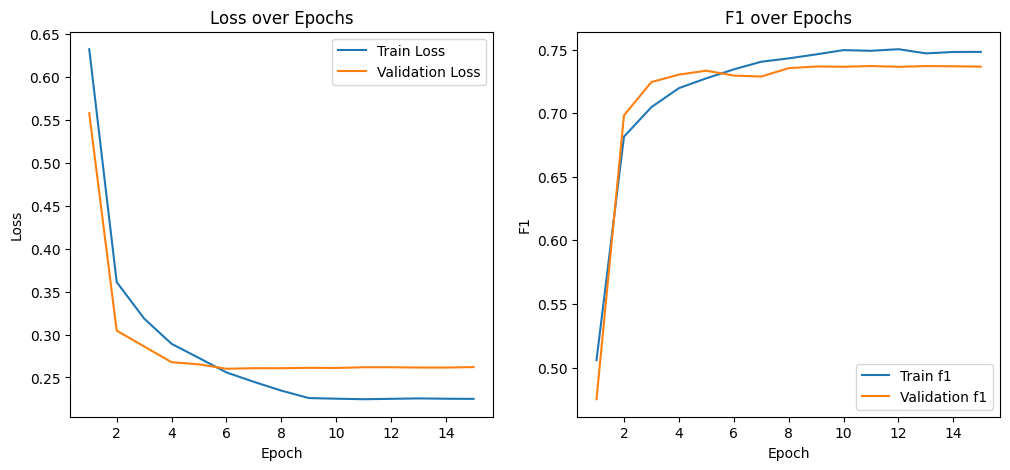

100%|██████████| 15/15 [01:11<00:00,  4.79s/it]

Epoch 15/15 | LR: 0.001000 | Train Loss: 0.2250, Train f1: 0.75 | Val Loss: 0.2621, Val f1: 0.74
EarlyStopping counter: 5 out of 3


In [386]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

metric = MultilabelF1Score(num_labels=20)  
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)
early_stopping_loss_switch = EarlyStopping(patience=2, verbose=True)

warmup_epochs = 2
base_lr = 0.01
loss_switched = False
optimizer_switched = False
num_epochs=15

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    if epoch < warmup_epochs:
         optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:  
         scheduler.step()
        
    all_preds_train = []
    all_labels_train = []
    
    for inputs, targets in train_loader:
        inputs = inputs.long().to(device)
        targets= targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        predicted =  torch.sigmoid(outputs)
        
        all_preds_train.append(predicted.cpu())
        all_labels_train.append(targets.cpu())

    all_preds_train = torch.cat(all_preds_train, dim=0)
    all_labels_train = torch.cat(all_labels_train, dim=0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc =  metric(all_preds_train,all_labels_train)
    
    all_preds_val = []
    all_labels_val = []
    
    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.long().to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs).to(device)

            all_preds_val.append(predicted.cpu())
            all_labels_val.append(targets.cpu())
            
    all_preds_val = torch.cat(all_preds_val, dim=0)
    all_labels_val = torch.cat(all_labels_val, dim=0)   
    
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = metric(all_preds_val,all_labels_val)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.cpu().item())
    val_accuracies.append(val_acc.cpu().item())

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train f1")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation f1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title("F1 over Epochs")
    plt.legend()
    plt.show()
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train f1: {train_acc:.2f} | Val Loss: {val_loss:.4f}, Val f1: {val_acc:.2f}")

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

Видно, что после 8-10 эпохи обучение пошло на спад и что скор, что лось особо не падают, f1 посредственная вышла

### 4.Встроенный эмбеддинг в нейросетевое решение на рекурентных сетях

Как обычно: стоп-слова и любая символьная/численная чушь в мусор, оставляем рус слова и навешиваем на них лемматизацию, попробуем оставить пунктуацию

In [16]:
def rnn_rus(text, method='lemmer'):
    text = text.lower()
    text = re.sub(r'[^а-яё\s\,-]', '', text)
    text = re.sub(r'-',' ',text)
    tokens = text.split()
    if method == 'lemmer':
        tokens = [lemmer_rus.parse(token)[0].normal_form for token in tokens]
    elif method == 'stemmer':
        tokens = [stemmer_rus.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words_rus and len(token) > 2]
    return ' '.join(tokens)

In [17]:
df['clean_text_rnn']= df.text.apply(lambda x: rnn_rus(x,'lemmer'))

In [18]:
t = [word_tokenize(sent, language='russian') for sent in df.clean_text_rnn.values]
tokens=[]
for sent in t:
     for word in sent:
        tokens.append(word) 
vocab = Counter(tokens)
vocab = {word: i + 2 for i, (word, _) in enumerate(vocab.most_common())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

inv_vocab = {idx: word for word, idx in vocab.items()}
vocab_size = len(vocab)

sequences = [vocab.get(word, vocab['<UNK>']) for word in tokens]

In [19]:
class My_Dataset_rnn(Dataset):
    def __init__(self, text, label, vocab,split='train',max_len=70):
        n=len(text)
        self.split=split
        self.vocab=vocab
        self.max_len=max_len
        
        if self.split == 'train':
            self.text=text[:int(n*0.7)]
            self.label=label[:int(n*0.7)]
        elif self.split == 'val':
            self.text=text[int(n*0.7):]
            self.label=label[int(n*0.7):]
        else:
            self.text=text
            self.label=label
                
    def __len__(self):
        return len(self.text)  

    def __getitem__(self, idx):
        doc = self.text[idx].split()
        seq = [self.vocab.get(word, self.vocab['<UNK>']) for word in doc][:self.max_len]
        if len(seq) < self.max_len:
            seq = seq + [self.vocab['<PAD>']] * (self.max_len - len(doc))
        doc_tensor = torch.FloatTensor(np.array(seq))  
        return doc_tensor, self.label[idx]

In [22]:
train_dataset=My_Dataset_rnn(df.clean_text_rnn.values,labels_tensor,vocab,split='train',max_len=70)
val_dataset=My_Dataset_rnn(df.clean_text_rnn.values,labels_tensor,vocab,split='val',max_len=70)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [23]:
class LSTMModel(nn.Module):
    def __init__(self,vocab_size, emb_dim=256, num_classes=20):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, 128, batch_first=True)
        self.fc1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, (hidden, cell) = self.lstm(x)
        last_hidden = out[:, -1, :]
        x = self.relu(self.fc1(last_hidden))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
model=LSTMModel(vocab_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

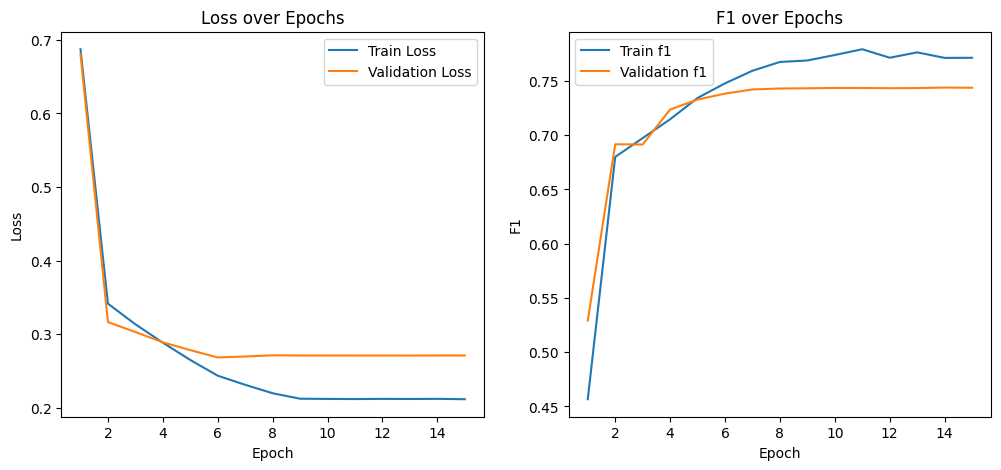

100%|██████████| 15/15 [01:29<00:00,  5.94s/it]

Epoch 15/15 | LR: 0.001000 | Train Loss: 0.2119, Train f1: 0.77 | Val Loss: 0.2713, Val f1: 0.74
EarlyStopping counter: 2 out of 3


In [25]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

metric = MultilabelF1Score(num_labels=20)  
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)
early_stopping_loss_switch = EarlyStopping(patience=2, verbose=True)

warmup_epochs = 2
base_lr = 0.01
loss_switched = False
optimizer_switched = False
num_epochs=15

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    if epoch < warmup_epochs:
         optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:  
         scheduler.step()
        
    all_preds_train = []
    all_labels_train = []
    
    for inputs, targets in train_loader:
        inputs = inputs.long().to(device)
        targets= targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        predicted =  torch.sigmoid(outputs)
        
        all_preds_train.append(predicted.cpu())
        all_labels_train.append(targets.cpu())

    all_preds_train = torch.cat(all_preds_train, dim=0)
    all_labels_train = torch.cat(all_labels_train, dim=0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc =  metric(all_preds_train,all_labels_train)
    
    all_preds_val = []
    all_labels_val = []
    
    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.long().to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs).to(device)

            all_preds_val.append(predicted.cpu())
            all_labels_val.append(targets.cpu())
            
    all_preds_val = torch.cat(all_preds_val, dim=0)
    all_labels_val = torch.cat(all_labels_val, dim=0)   
    
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = metric(all_preds_val,all_labels_val)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.cpu().item())
    val_accuracies.append(val_acc.cpu().item())

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train f1")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation f1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title("F1 over Epochs")
    plt.legend()
    plt.show()
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train f1: {train_acc:.2f} | Val Loss: {val_loss:.4f}, Val f1: {val_acc:.2f}")

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

Тут выводы те же, метрика не очень, так что для выбития на лидерборде чего-то адекватного пока что остается tf-idf 

### 5. Эмбеддер + решение на bert-like моделях (любой вид). 

тут предобработка не нужна, моделька уже все учла

In [3]:
class My_Dataset_bert(Dataset):
    def __init__(self, text, label, tokenizer, max_len=64,split='train'):
        self.text = text
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.split=split
        
        n=len(self.text)
        if self.split == 'train':
            self.text=text[:int(n*0.7)]
            self.label=label[:int(n*0.7)]
        elif self.split == 'val':
            self.text=text[int(n*0.7):]
            self.label=label[int(n*0.7):]
        else:
            self.text=text
            self.label=label
            
    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = str(self.text[idx])
        label = self.label[idx]
        encoding = self.tokenizer(text,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len,
                                  return_tensors='pt')
        return {'input_ids': encoding['input_ids'].squeeze(),
                'attention_mask': encoding['attention_mask'].squeeze(),
                'label': label}


In [4]:
labels_tensor=torch.FloatTensor(np.array([np.fromstring(row, dtype=int, sep=' ') for row in df['labels'].values]))

In [24]:
model_name = 'DeepPavlov/rubert-base-cased'
#model_name='sberbank-ai/ruBert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = My_Dataset_bert(df.text.values, labels_tensor, tokenizer,split='train')
val_dataset = My_Dataset_bert(df.text.values,labels_tensor, tokenizer,split='val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [25]:
for i in train_loader:
    break

In [26]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_labels=20):
        super().__init__()
        self.bert = bert_model
        for param in self.bert.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = output.pooler_output
        return self.classifier(cls_token)

In [29]:
bert_model = AutoModel.from_pretrained(model_name)
model = BertClassifier(bert_model)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

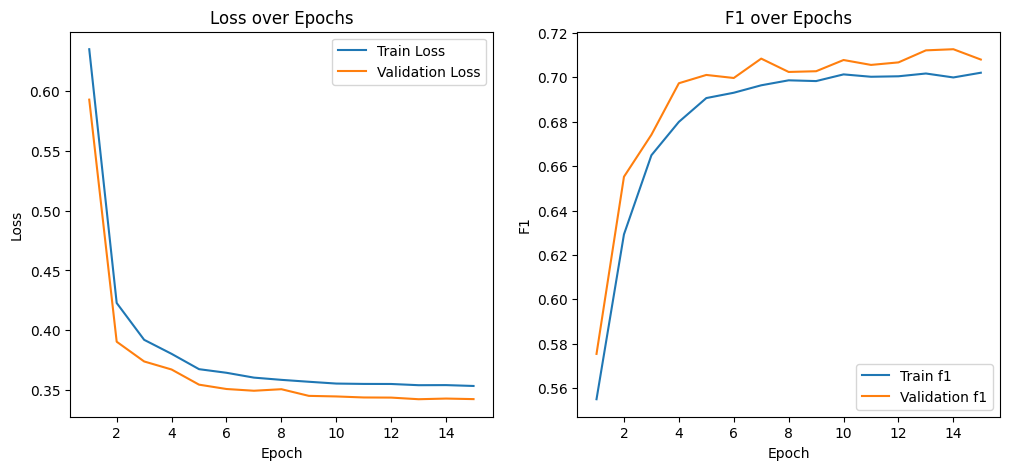

100%|██████████| 15/15 [15:38<00:00, 62.58s/it]

Epoch 15/15 | LR: 0.000104 | Train Loss: 0.3533, Train f1: 0.70 | Val Loss: 0.3423, Val f1: 0.71
EarlyStopping counter: 2 out of 2
No improvement after loss switch. Switching optimizer to Adam.


In [31]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

metric = MultilabelF1Score(num_labels=20)  
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)
early_stopping_loss_switch = EarlyStopping(patience=2, verbose=True)

warmup_epochs = 3
base_lr = 0.01
loss_switched = False
optimizer_switched = False
num_epochs=15

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0
    
    if epoch < warmup_epochs:
         optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:  
         scheduler.step()
        
    all_preds_train = []
    all_labels_train = []
    

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 

        running_loss += loss.item() * input_ids.size(0)
        predicted =  torch.sigmoid(outputs)
        
        all_preds_train.append(predicted.cpu())
        all_labels_train.append(labels.cpu())

    all_preds_train = torch.cat(all_preds_train, dim=0)
    all_labels_train = torch.cat(all_labels_train, dim=0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc =  metric(all_preds_train,all_labels_train)
    
    all_preds_val = []
    all_labels_val = []
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
        
            loss = criterion(outputs, batch_labels)
            running_val_loss += loss.item() * input_ids.size(0)
            predicted = torch.sigmoid(outputs).to(device)

            all_preds_val.append(predicted.cpu())
            all_labels_val.append(batch_labels.cpu())
            
    all_preds_val = torch.cat(all_preds_val, dim=0)
    all_labels_val = torch.cat(all_labels_val, dim=0)   
    
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = metric(all_preds_val,all_labels_val)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.cpu().item())
    val_accuracies.append(val_acc.cpu().item())

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train f1")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation f1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title("F1 over Epochs")
    plt.legend()
    plt.show()
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train f1: {train_acc:.2f} | Val Loss: {val_loss:.4f}, Val f1: {val_acc:.2f}")

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

### Часть 4: Попытки генерации



In [27]:
model_name = 'sberbank-ai/rugpt2large'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

In [32]:
start=[]
label=[]
for i in range(1000):
    start.append(df[df.labels==df.labels.unique()[i]].reset_index(drop=True).clean_text_rnn[0])
    label.append(df[df.labels==df.labels.unique()[i]].reset_index(drop=True).labels[0])
    for i in range(len(start)):
        start[i]=' '.join(start[i].split()[:10]) #1000 промптов для первых 1000 уникальных меток из каждой уникальной метки берем первое предложение и от него первые 10 слов

In [33]:
gen_text=[]
for i in start:
    prompt_text = i
    input_ids = tokenizer.encode(prompt_text, return_tensors='pt').cuda()
    
    output_ids = model.generate(
    input_ids=input_ids,
    max_length=110,
    temperature=0.8,
    top_k=40,
    top_p=0.95,
    do_sample=True,
    num_return_sequences=1)
    
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    gen_text.append(generated_text)
    

2025-05-18 22:00:50.796050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [34]:
new_labels=np.append(label,df.labels.values)
new_texts=np.append(gen_text,df['text'].values)
new_df=pd.DataFrame({'labels':new_labels,
              'text':new_texts})
new_df.to_csv('train_gen.csv', index=False)

In [35]:
def tf_idf_rus(text, method='lemmer'):
    text = text.lower()
    text = re.sub(r'[^а-яё\s-]', '', text)
    text = re.sub(r'-',' ',text)
    tokens = text.split()
    if method == 'lemmer':
        tokens = [lemmer_rus.parse(token)[0].normal_form for token in tokens]
    elif method == 'stemmer':
        tokens = [stemmer_rus.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words_rus and len(token) > 2]
    return ' '.join(tokens)

In [36]:
new_df['clean_text']= new_df.text.apply(lambda x: tf_idf_rus(x,method='lemmer'))
#labels_tensor=torch.FloatTensor(np.array([np.fromstring(row, dtype=int, sep=' ') for row in new_df['labels'].values]))

In [37]:
df_mixed=new_df.sample(frac=1).reset_index(drop=True)

In [38]:
labels_tensor=torch.FloatTensor(np.array([np.fromstring(row, dtype=int, sep=' ') for row in df_mixed['labels'].values]))

In [39]:
tf_idf = TfidfVectorizer(
    max_df=0.95,      
    min_df=1,
    norm='l2',        
sublinear_tf=True
)
X = tf_idf.fit_transform(df_mixed.clean_text) 
X_tensor = torch.FloatTensor(X.toarray())

In [42]:
train_dataset=My_Dataset(X_tensor,labels_tensor,split='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset=My_Dataset(X_tensor,labels_tensor,split='val')
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_classes = 20
num_uwords=X_tensor.shape[1]

model = nn.Sequential(
    nn.Linear(num_uwords,2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    
    nn.Linear(2048,1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.4),
    
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512,num_classes)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

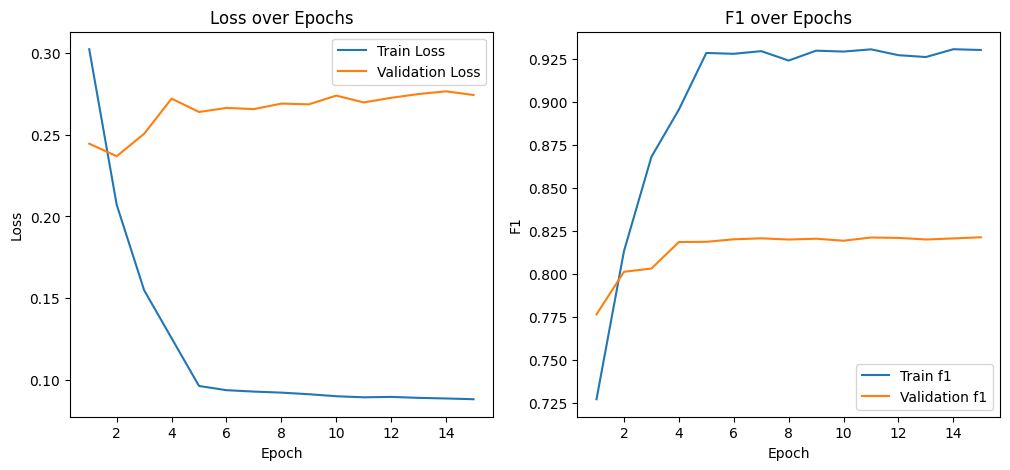

100%|██████████| 15/15 [04:54<00:00, 19.65s/it]

Epoch 15/15 | LR: 0.001000 | Train Loss: 0.0880, Train f1: 0.93 | Val Loss: 0.2744, Val f1: 0.82
EarlyStopping counter: 10 out of 2


In [43]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

metric = MultilabelF1Score(num_labels=20)  
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)
early_stopping_loss_switch = EarlyStopping(patience=2, verbose=True)

warmup_epochs = 2
base_lr = 0.01
loss_switched = False
optimizer_switched = False
num_epochs=15

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    # if epoch < warmup_epochs:
    #      optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    # else:  
    #      scheduler.step()
        
    all_preds_train = []
    all_labels_train = []
    
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets= targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        predicted =  torch.sigmoid(outputs)
        
        all_preds_train.append(predicted.cpu())
        all_labels_train.append(targets.cpu())

    all_preds_train = torch.cat(all_preds_train, dim=0)
    all_labels_train = torch.cat(all_labels_train, dim=0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc =  metric(all_preds_train,all_labels_train)
    
    all_preds_val = []
    all_labels_val = []
    
    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs).to(device)

            all_preds_val.append(predicted.cpu())
            all_labels_val.append(targets.cpu())
            
    all_preds_val = torch.cat(all_preds_val, dim=0)
    all_labels_val = torch.cat(all_labels_val, dim=0)   
    
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = metric(all_preds_val,all_labels_val)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.cpu().item())
    val_accuracies.append(val_acc.cpu().item())

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train f1")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation f1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title("F1 over Epochs")
    plt.legend()
    plt.show()
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train f1: {train_acc:.2f} | Val Loss: {val_loss:.4f}, Val f1: {val_acc:.2f}")

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)

##### Выводы при добавлении генерации в датасет: переобучение не ушло, сгенеренные данные добавлялись сначала во весь трейн, а потом там перемешивались и датасет делился на трейн валидцию, те моделька также предсказывает какую-то часть меток сгенеренных, скор не улучшился, но тут кстати в препроцессинге текста убирались англ слова, чтобы было легче строить генерацию

# Скор 

In [7]:
with open('requirements.txt', 'r') as f:
    lines = f.readlines()

with open('requirements.txt', 'w') as f:
    for line in lines:
        if '/app/ml_kernel' not in line.strip():
            f.write(line)
            

In [8]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Processing /default/cloud_ml (from -r requirements.txt (line 54))
  Preparing metadata (setup.py) ... done
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0-py3-none-any.whl (12.8 MB)
  Using cached https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.4.13+cuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl (188.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB ? eta 0:00:00a 0:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 5.1 MB/s eta 0:00:00ta 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 1.5 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.5/662.5 kB 109.1 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is availab

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets,models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
from tqdm import tqdm
import os
import zipfile
import seaborn as sns
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from nltk.stem.snowball import RussianStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
import torchmetrics
from torchmetrics.classification import MultilabelF1Score
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from gensim.models import Word2Vec
from collections import Counter
from nltk.tokenize import word_tokenize
from transformers import AutoModel, AutoTokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [41]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience #отвечает за период в течении которого не улучшается метрика 
        self.verbose = verbose
        self.counter = 0 #счетчик увеличивается каждую эпоху, если не было улучшения 
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta: #делта чтобы не сохранялись совсем маленькие приросты 
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
            
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs: # пока идут эпохт вормапа lr изменяется по определенному закону 
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer  
def tf_idf_both(text):
    
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #удаляем ссылки 
    text = re.sub(r'@\S+', '', text) #удаляем теги почт и тг
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s-]', '', text)  #убираем все кроме рус/англ букв и - 
    text = re.sub(r'-',' ',text) #были слова по типу "перфоманс-инсталляция" сделали так чтобы убрать - и не было слипаний 
    
    tokens = text.split()
    #для русского лемматизация для английского стемминг
    tokens = [lemmer_rus.parse(token)[0].normal_form if re.search('[а-яё]', token) else stemmer_eng.stem(token) for token in tokens]
    
    tokens = [token for token in tokens if token not in (stop_words_eng and stop_words_rus) and len(token) > 2]
    return ' '.join(tokens)

class My_Dataset(Dataset):
    def __init__(self, text, label, split='train'):
        n=text.shape[0]
        self.split=split
        if self.split == 'train':
            self.text=text[:int(n*0.7)]
            self.label=label[:int(n*0.7)]
        elif self.split == 'val':
            self.text=text[int(n*0.7):]
            self.label=label[int(n*0.7):]
        else:
            self.text=text
            self.label=label
                
    def __len__(self):
        return self.text.shape[0]  

    def __getitem__(self, idx):
        return self.text[idx], self.label[idx]
    
class test_Dataset(Dataset):
    def __init__(self, text):
            self.text=text
                
    def __len__(self):
        return self.text.shape[0]  

    def __getitem__(self, idx):
        return self.text[idx]    
    
nltk.download('stopwords') 
nltk.download('omw-1.4')
import inspect
if not hasattr(inspect, 'getargspec'):
    import collections
    def getargspec(func):
        sig = inspect.signature(func)
        args = []
        varargs = None
        varkw = None
        defaults = []
        for param in sig.parameters.values():
            if param.kind == param.VAR_POSITIONAL:
                varargs = param.name
            elif param.kind == param.VAR_KEYWORD:
                varkw = param.name
            else:
                args.append(param.name)
                if param.default is not param.empty:
                    defaults.append(param.default)
        return collections.namedtuple('ArgSpec', 'args varargs keywords defaults')(args, varargs, varkw, tuple(defaults) if defaults else None)
    inspect.getargspec = getargspec
lemmer_rus = pymorphy2.MorphAnalyzer() 
lemmer_eng = WordNetLemmatizer()
#лемматизация 
stemmer_rus = RussianStemmer()
stemmer_eng =PorterStemmer()#стемматизация

stop_words_rus = set(stopwords.words('russian'))
stop_words_eng =set(stopwords.words('english'))    

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


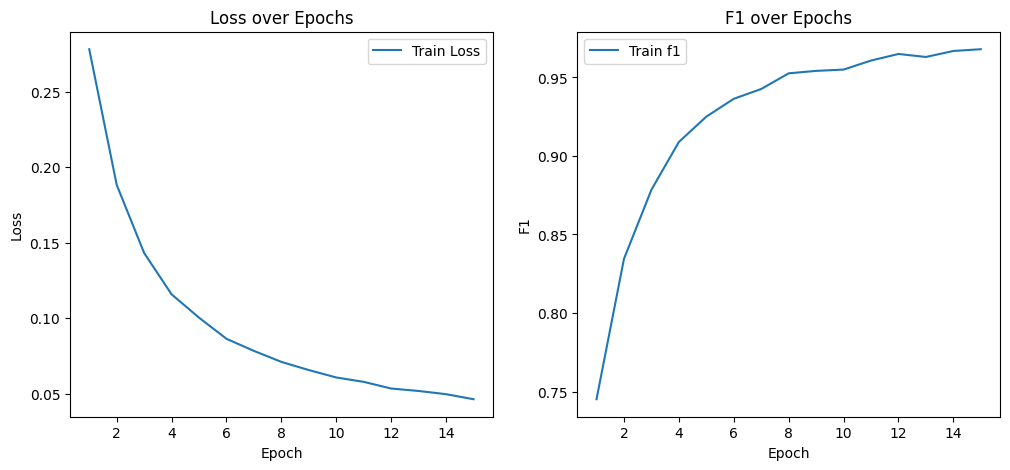

100%|██████████| 15/15 [09:52<00:00, 39.47s/it]

Epoch 15/15 | LR: 0.001000 | Train Loss: 0.0465, Train f1: 0.97


In [14]:
df=pd.read_csv('content2/train.csv')
df['clean_text']= df.text.apply(lambda x: tf_idf_both(x))
labels_tensor=torch.FloatTensor(np.array([np.fromstring(row, dtype=int, sep=' ') for row in df['labels'].values]))

tf_idf = TfidfVectorizer(
     max_df=0.95,      
     min_df=1,
     norm='l2',        
 sublinear_tf=True
)
X = tf_idf.fit_transform(df.clean_text) 
X_tensor = torch.FloatTensor(X.toarray())


train_dataset=My_Dataset(X_tensor,labels_tensor,split=None)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

num_classes = 20
num_uwords=X_tensor.shape[1]

model = nn.Sequential(
    nn.Linear(num_uwords,2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    
    nn.Linear(2048,1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.4),
    
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512,num_classes)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

metric = MultilabelF1Score(num_labels=20)  
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)
early_stopping_loss_switch = EarlyStopping(patience=2, verbose=True)

warmup_epochs = 2
base_lr = 0.01
loss_switched = False
optimizer_switched = False
num_epochs=15

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0
    
    # if epoch < warmup_epochs:
    #      optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    # else:  
    #      scheduler.step()
        
    all_preds_train = []
    all_labels_train = []
    
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets= targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        predicted =  torch.sigmoid(outputs)
        
        all_preds_train.append(predicted.cpu())
        all_labels_train.append(targets.cpu())

    all_preds_train = torch.cat(all_preds_train, dim=0)
    all_labels_train = torch.cat(all_labels_train, dim=0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc =  metric(all_preds_train,all_labels_train)
    

    train_losses.append(train_loss)
    train_accuracies.append(train_acc.cpu().item())

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train f1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title("F1 over Epochs")
    plt.legend()
    plt.show()
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train f1: {train_acc:.2f}")# | Val Loss: {val_loss:.4f}, Val f1: {val_acc:.2f}")

    early_stopping_optimizer_switch(train_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer =optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)

In [15]:
model.load_state_dict(early_stopping_optimizer_switch.best_model_state)
test=pd.read_csv('content2/test.csv')

test['clean_text']=test.text.apply(lambda x: tf_idf_both(x))

X = tf_idf.transform(test.clean_text) 
X_tensor = torch.FloatTensor(X.toarray())


test_dataset=test_Dataset(X_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
test_predictions = []
for inputs in test_loader:
    inputs=inputs.to(device)
    with torch.no_grad():
        outputs=model(inputs)
        preds=torch.sigmoid(outputs)
        preds = (preds >= 0.5).float()
        test_predictions.extend(preds.cpu().numpy().tolist())
print(len(test_predictions))      

tags=pd.read_csv('/home/jupyter/datasphere/project/content2/sample_submission.csv')
tags['labels']=[' '.join(map(str, map(int, i))) for i in test_predictions]
tags.to_csv('end.csv', index=False) 


7392
